In [1]:
from datetime import datetime, timedelta
import pickle
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from tldextract import extract
import langid

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

from newspaper import Article
import matplotlib.pyplot as plt

<ipython-input-1-cd00b3c2a068>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


NOTE: Mediacloud news for state-specific collection includes news ABOUT the particular state, and as such, might sometimes contain news from national outlets where the article itself might be focused on the state itself. Most (if not all) of the collection is going to be sourced from local state-specific outlets, but not always. Currently, we are keeping all URLs within the obtained collection for the state, except those from nytimes and foxnews since those are our chosen national outlets. Trusting mediacloud's collections to be truly state-focused even when urls come from national outlets. 

In [2]:
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()

In [3]:
cali_news = pd.read_csv('data/mediacloud_california.csv')
print(cali_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17155 entries, 0 to 17154
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   archived_url  17155 non-null  object
 1   article_url   17155 non-null  object
 2   id            17155 non-null  int64 
 3   language      17155 non-null  object
 4   media_name    17155 non-null  object
 5   media_url     17155 non-null  object
 6   publish_date  17155 non-null  object
 7   title         17155 non-null  object
 8   url           17155 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.2+ MB
None


In [4]:
#analyze the distribution across months of publication -- are there gaps in the collection?
all_dates = list(cali_news['publish_date'])
month_to_vol = {}
for i in range(1, 13):
    month_to_vol[i] = 0
for d in tqdm(all_dates):
    m = int(d.split('-')[1])
    month_to_vol[m] += 1

100%|██████████| 17155/17155 [00:00<00:00, 903141.52it/s]


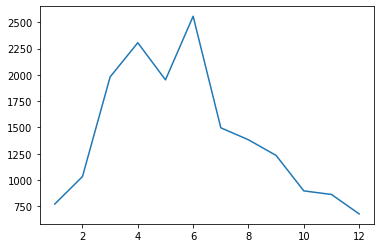

In [5]:
plt.plot(list(month_to_vol.keys()), list(month_to_vol.values()))

In [6]:
cali_news[['language', 'media_name', 'media_url', 'publish_date', 'title', 'url']].tail(20)

,language,media_name,media_url,publish_date,title,url
17135,en,voiceofoc.org,http://voiceofoc.org,2023-03-10 00:00:00,Edwards and Palumbo: The Pride Flag Should Fly in the Name of True Community,https://voiceofoc.org/2023/03/edwards-and-palumbo-the-pride-flag-should-fly-in-the-name-of-true-community/
17136,en,voiceofoc.org,http://voiceofoc.org,2023-03-08 00:00:00,Now Covered Under OC’s Health Plan for the Poor: Affordable Housing Construction,https://voiceofoc.org/2023/03/now-covered-under-ocs-health-plan-for-the-poor-affordable-housing-construction/
17137,en,voiceofoc.org,http://voiceofoc.org,2023-06-06 00:00:00,OC Supervisors Ban Pride Flag at County Properties Under New Policy,https://voiceofoc.org/2023/06/oc-supervisors-ban-pride-flag-at-county-properties-under-new-policy/
17138,en,voiceofoc.org,http://voiceofoc.org,2023-06-30 00:00:00,"Wade and Gonzales: Stop Orange County's Attack on Pride, a Demand Letter from OC's LGBTQ+ Community",https://voiceofoc.org/2023/06/wade-and-gonzales-stop-orange-countys-attack-on-pride-a-demand-letter-from-ocs-lgbtq-community/
17139,en,voiceofoc.org,http://voiceofoc.org,2023-06-06 00:00:00,Will OC Supervisors Keep the Pride Flag From Flying Outside County Offices?,https://voiceofoc.org/2023/06/will-oc-supervisors-keep-the-pride-flag-from-flying-outside-county-offices/
17140,en,voiceofoc.org,http://voiceofoc.org,2023-08-22 00:00:00,Orange Unified School District Considers Notifying Parents of Transgender Students,https://voiceofoc.org/2023/08/orange-unified-school-district-considers-notifying-parents-of-transgender-students/
17141,en,voiceofoc.org,http://voiceofoc.org,2023-09-08 00:00:00,An OC School District Adopts Transgender Notification; State AG Issues Legal Threat,https://voiceofoc.org/2023/09/an-oc-school-district-adopts-transgender-notification-state-ag-issues-legal-threat/
17142,en,voiceofoc.org,http://voiceofoc.org,2023-09-27 00:00:00,Min and Bernstein: Importance of LGBTQ+ Pride in OC,https://voiceofoc.org/2023/09/min-and-bernstein-importance-of-lgbtq-pride-in-oc/
17143,en,voiceofoc.org,http://voiceofoc.org,2023-09-21 00:00:00,New Report Shows Hate Crimes and Incidents Continue Increasing in Orange County¬†,https://voiceofoc.org/2023/09/new-report-shows-hate-crimes-and-incidents-continue-increasing-in-orange-county/
17144,en,voiceofoc.org,http://voiceofoc.org,2023-09-07 00:00:00,Will Orange Unified Approve a Transgender Outing Policy Despite State Legal Threats?,https://voiceofoc.org/2023/09/will-orange-unified-approve-a-transgender-outing-policy-despite-state-legal-threats/


In [7]:
relevant_news = cali_news[~cali_news['media_name'].isin(['foxnews.com',
                                                         'nytimes.com'])]
relevant_news = relevant_news[relevant_news['language']=='en']
relevant_news = relevant_news[['media_name', 'publish_date', 'title', 'url']]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15969 entries, 0 to 17154
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   media_name    15969 non-null  object
 1   publish_date  15969 non-null  object
 2   title         15969 non-null  object
 3   url           15969 non-null  object
dtypes: object(4)
memory usage: 623.8+ KB
None


In [8]:
relevant_news.publish_date = pd.to_datetime(relevant_news.publish_date)
relevant_news = relevant_news[relevant_news['publish_date'].dt.date >= start_date]
relevant_news = relevant_news[relevant_news['publish_date'].dt.date <= end_date]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15969 entries, 0 to 17154
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    15969 non-null  object        
 1   publish_date  15969 non-null  datetime64[ns]
 2   title         15969 non-null  object        
 3   url           15969 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 623.8+ KB
None


In [9]:
def get_article_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        subtitle = article.meta_description
        if subtitle == '' or subtitle == ' ':
            subtitle = None
        text = article.text
        if text == '' or text == ' ':
            text = None
    except:
        subtitle = None
        text = None
    return subtitle, text

In [10]:
subtitles, texts = [], []
all_urls = list(relevant_news['url'])
for url in tqdm(all_urls):
    subtitle, text = get_article_from_url(url)
    subtitles.append(subtitle)
    texts.append(text)
relevant_news['subtitle'] = subtitles
relevant_news['text'] = texts
print(relevant_news.info())

100%|██████████| 15969/15969 [3:38:34<00:00,  1.22it/s]  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15969 entries, 0 to 17154
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    15969 non-null  object        
 1   publish_date  15969 non-null  datetime64[ns]
 2   title         15969 non-null  object        
 3   url           15969 non-null  object        
 4   subtitle      10067 non-null  object        
 5   text          14450 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 873.3+ KB
None


In [11]:
relevant_news.to_csv('data/california_article_texts_and_info.csv',
                     index=False)